In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figures').absolute()

df_meta_path = data_dir /'13cyc'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


# Read PPI data

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [6]:
# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()

# Generate PPI network

In [19]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
from libpysal import weights
from itertools import count
from libpysal.cg import voronoi_frames
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def create_network(df, t=50, scale=0.2):   
    y,x = df['y'].to_numpy(), df['x'].to_numpy()

    # Get coordinates
    coordinates = np.vstack([x, y]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

def create_network3(df, t=50):    
    # Get coordinates
    coordinates = np.column_stack((df.x, df.y))
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    vcells, generators = voronoi_frames(points, clip="chull")
    delaunay = weights.Rook.from_dataframe(vcells)
    g_de = delaunay.to_networkx()  
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(g_de.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

In [8]:
# graph_save_path =  data_dir / '13cyc' / 'graphs' / 'raw'
# graph_save_path.mkdir(parents=True, exist_ok=True)

# group = df.groupby(['Condition', 'FOV', 'Cyto'])

# for name, df_group in tqdm(group, total=len(group)):
#     # Remove duplicated 
#     df_group.drop_duplicates(subset=['x', 'y', 'PPI'],
#                              keep='first', inplace=True)
    
#     # Add small variatio to close PPI 
#     while df_group.duplicated(subset=['x', 'y']).any():
#         df_group.loc[df_group.duplicated(subset=['x', 'y']), ['x', 'y']] += [1,1] 
    
#     if len(df_group) < 5:
#         continue

#     # Generate graph and inf
#     g = create_network(df_group)
#     if nx.number_of_isolates(g)>0:
#         print('Isolated nodes')
        
#     # Save pgrahs
#     save_path = graph_save_path / ('_'.join([str(n) for n in name])+'.pkl')
#     with open(save_path, 'wb') as f:
#         pickle.dump(g, f, protocol=pickle.HIGHEST_PROTOCOL)

# Visualize PPI network with networkx

In [20]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax
    
def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

In [21]:
import palettable
from sklearn.preprocessing import OneHotEncoder

# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_20.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['AKT/Mtor', 'Bim/Tom20', 'Cyclin D1/CDK4', 'Cyclin E/CDK2',
       'EGFR/GRB2', 'FoxO1/AKT', 'Mcl-1/BAK', 'NF-Kb/p-P90rsk',
       'SIRT1/P53', 'Sox2/Oct4', 'TEAD1/YAP', 'TRAIL/DR5', 'p-ERK/c-MYC'],
      dtype=object)]


In [22]:
import PLA

graph_save_path =  data_dir / '13cyc' / 'graphs' / 'raw'
contour_save_path =  data_dir / '13cyc'/ 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [12]:
# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'pos', 'labels', 'nuclei'}


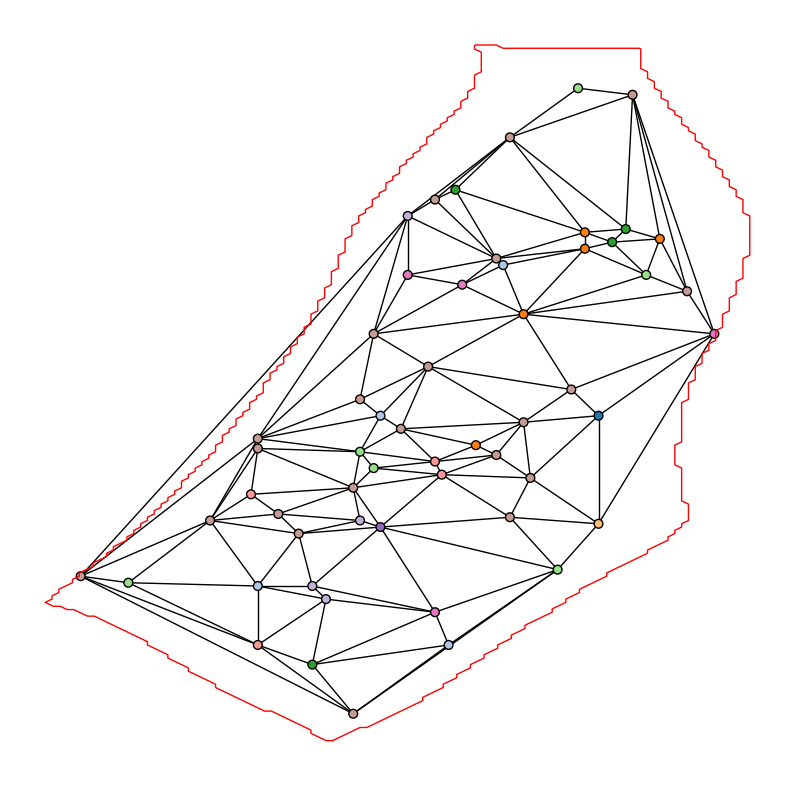

In [13]:
df_subset = cell_data.df.sample(10, random_state=0)

for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    
    # Plot
    f, ax = plt.subplots(figsize=(10,10))
    ax = plot_network(network,  node_colors , ax, node_size=40, edgecolors='k')
    plot_contour(contour_cell, None, ax, linewidth=1)
    ax.invert_yaxis()
    plt.show()
    break

In [14]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
from libpysal import weights
from itertools import count
from libpysal.cg import voronoi_frames
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def create_network(x,y, t=50, scale=0.2):   

    # Get coordinates
    coordinates = np.vstack([x, y]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    return g

In [15]:
pos = nx.get_node_attributes(network, 'pos')
pos_a = np.array(list(pos.values()))
x = pos_a[:,1]
y = pos_a[:,0]

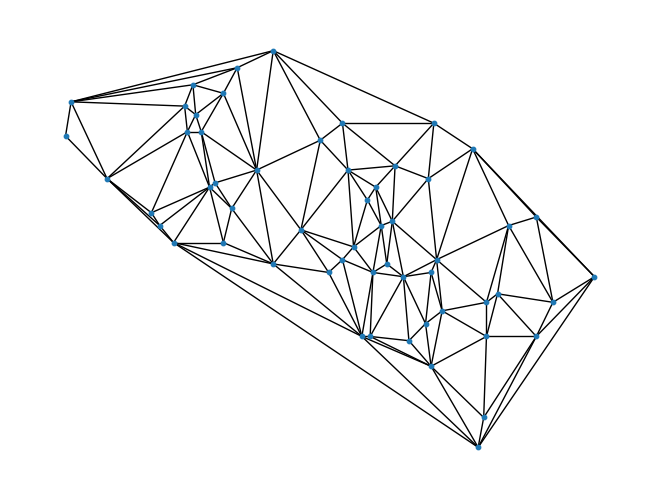

In [16]:
nx.draw(network, pos, with_labels=False, node_size=10)


# Plot raw images

In [12]:
from skimage.morphology import white_tophat as skimage_white_tophat
from copy import deepcopy

# Read images
def read_img_bbox(path, bbox, pad = 20):
    min_y, min_x, max_y, max_x = bbox
    min_y = np.clip(min_y - pad, a_min=0, a_max=None)
    min_x = np.clip(min_x - pad, a_min=0, a_max=None)
    max_y += pad
    max_x += pad
    
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][..., min_y:max_y, min_x:max_x]
    
    return imgs, markers

def white_tophat(image, radius):
        # ensure iterable radius
        if not isinstance(radius, (tuple, list, np.ndarray)):
            radius = (radius,)*image.ndim

        # convert to footprint shape
        shape = [2*r+1 for r in radius]

        # run white tophat
        return skimage_white_tophat(image, footprint=np.ones(shape))
    
    
def plot_contour_mean(contour_cell, contour_nuclei, offset, ax, linewidth=1):
    contour = deepcopy(max(contour_cell, key = len))
    contour -= np.array(offset)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = deepcopy(max(contour_nuclei, key = len))
        contour -= np.array(offset)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass
    
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

blue = LinearSegmentedColormap.from_list(
        "Blue", [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0]])

def plot_PPI(imgs, markers, contour_cell, contour_nuclei, offset, ax, 
             colors_rgb_dict=colors_rgb_dict, 
             q_min=0.9,
             q_max=0.998,
             subset=['Hoeschst', 'TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK'],
             DAPI = True):
    for i in range(len(subset)):
        indice = list(markers).index(subset[i])
        if i == 0 and DAPI:
            c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                            [[0.0, 0.0, 0.0, 0.0], 
                                             [0,1,1,1]])
            ax.imshow(imgs[indice], vmin=0, vmax=np.quantile(imgs[indice], q_max), cmap=c_cmap)
        else:
            # Get custom colormap 
            c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                            [[0.0, 0.0, 0.0, 0.0], 
                                             np.array(list(colors_rgb_dict[subset[i]])+[255])/255])
            ax.imshow(imgs[indice], 
                      vmin=np.quantile(imgs[indice], q_min), 
                      vmax=np.quantile(imgs[indice], q_max), 
                      cmap=c_cmap)
    
    ax.axis('off')
    if contour_cell is not None:
        plot_contour_mean(contour_cell, contour_nuclei, offset, ax)

In [13]:
# 'Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',  'Cyclin D1/CDK4', 'Bim/Tom20', 
# 'EGFR/GRB2', 'FoxO1/AKT',  'p-ERK/c-MYC', 'Mcl-1/BAK',  'Cyclin E/CDK2',  'AKT/Mtor', 'TEAD1/YAP'

In [19]:
subset1 = ['Hoechst', 'Ki67', 'Pan-cytokeratin', 'p-EGFR',]
subset2 = ['Hoechst', 'NBD-C6',  'COX IV']
PPI_subset1 = ['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',  'Cyclin D1/CDK4', 'Bim/Tom20']
PPI_subset2 = ['EGFR/GRB2', 'FoxO1/AKT',  'p-ERK/c-MYC', 'Mcl-1/BAK',  'Cyclin E/CDK2',  'AKT/Mtor', 'TEAD1/YAP']

colors_rgb_dict_protein1 = {k:v for k,v in zip(subset1[1:], [[255,0,255], [0,255,0], [255,0,0]])}
colors_rgb_dict_protein2 = {k:v for k,v in zip(subset2[1:], [[255,0,255], [0,255,0]])}

In [20]:
fig_path = fig_dir / '13cyc' / 'Cell'
fig_path.mkdir(parents=True, exist_ok=True)    

In [21]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]

    if cell =='0':
        continue
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        pass
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Condition == row.Condition)].Path.item()
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = max(contour_cell, key = len)
    max_y, max_x = contour.max(axis=0).astype(int)
    min_y, min_x = contour.min(axis=0).astype(int)
    
    # Get mutiplex images
    img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)
    img = white_tophat(img, 3)
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
    
    with plt.style.context('dark_background'):
        # Plot Graph
        f, axs = plt.subplots(1, 5, figsize=(20,4), facecolor='k')
        ax = axs[0]
        plot_network(network,  node_colors, ax, node_size=60, edgecolors='w', width=1.5, edge_color='w')
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
        ax.set_facecolor('k')

        ax=axs[1]
        ax.set_facecolor('k')
        plot_PPI(img, markers, contour_cell, contour_nuclei, offset=[min_y-pad, min_x-pad], 
                 subset=PPI_subset1, ax=ax, DAPI=False)
        ax=axs[2]
        ax.set_facecolor('k')
        plot_PPI(img, markers, contour_cell, contour_nuclei, offset=[min_y-pad, min_x-pad], 
                 subset=PPI_subset2, ax=ax, DAPI=False)

        ax=axs[3]
        ax.set_facecolor('k')
        plot_PPI(img, markers, None, None, offset=[min_y-pad, min_x-pad], colors_rgb_dict=colors_rgb_dict_protein1,
                 subset = subset1,
                 q_min=0.01,
                 q_max=1.0,
                 ax=ax)

        ax=axs[4]
        ax.set_facecolor('k')
        plot_PPI(img, markers, None, None, offset=[min_y-pad, min_x-pad], colors_rgb_dict=colors_rgb_dict_protein2,
                 subset = subset2,
                 q_min=0.01,
                 q_max=1.0,
                 ax=ax)

        axs[0].invert_yaxis()
        axs[0].set_aspect('equal')
        f.set_facecolor("#00000F")
        f.subplots_adjust(wspace=0.01)
        f.suptitle(f'{key}_{cell}', fontsize=16, color='w')

        file_name = '_'.join([key, cell])
        f.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close()
    break

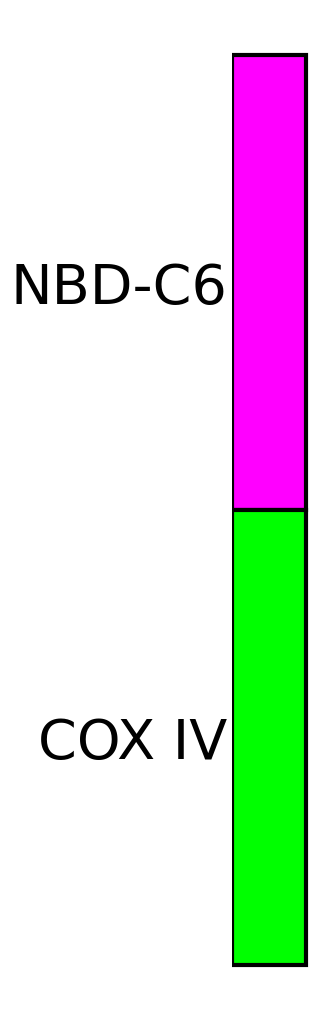

In [31]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict_protein2.values())), 
        color=np.array(list(colors_rgb_dict_protein2.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict_protein2.values())), colors_rgb_dict_protein2.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [23]:
# with h5py.File(path, "r") as f:
#     imgs = f['imgs'][:]
#     markers = f['imgs'].attrs['Marker']

In [24]:
# import napari 

# napari.view_image(imgs, channel_axis=0, name=markers, visible=False, contrast_limits=[0,255])

In [25]:
import napari 

napari.view_image(img, channel_axis=0, name=markers, visible=False, contrast_limits=[0,255])

RuntimeError: Using glBindFramebuffer with no OpenGL context.

Viewer(camera=Camera(center=(0.0, 56.5, 91.0), zoom=4.422950819672131, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 114.0, 1.0), (0.0, 183.0, 1.0)), current_step=(56, 91), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Hoechst' at 0x242d0918290>, <Image layer 'Sox2/Oct4' at 0x242d0943f90>, <Image layer 'NF-Kb/p-P90rsk' at 0x242d097a8d0>, <Image layer 'Hoechst [1]' at 0x242d14e50d0>, <Image layer 'SIRT1/P53' at 0x242d150b990>, <Image layer 'TRAIL/DR5' at 0x242d153e210>, <Image layer 'Hoechst [2]' at 0x242d156cad0>, <Image layer 'Cyclin D1/CDK4' at 0x242d159b390>, <Image layer 'Bim/Tom20' at 0x242d15c5c50>, <Image layer 'Hoechst [3]' at 0x242d153e250>, <Image layer 'EGFR/GRB2' at 0x242d1622d10>, <Image layer 'FoxO1/AKT' at 0x242d16515

# Whole FOV network plot

In [9]:
# Helper functions

import napari
import vispy.color
import networkx as nx
from copy import deepcopy 

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax


In [10]:
# Load custom class
import PLA

graph_save_path =  data_dir / '13cyc' / 'graphs' / 'raw'
contour_save_path =  data_dir / '13cyc'/ 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

# Define figure file 
fig_path = fig_dir / '13cyc' / 'FOV'
fig_path.mkdir(parents=True, exist_ok=True)    

Loading graphs
Loading contours


In [11]:
import palettable
from sklearn.preprocessing import OneHotEncoder

# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_20.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['AKT/Mtor', 'Bim/Tom20', 'Cyclin D1/CDK4', 'Cyclin E/CDK2',
       'EGFR/GRB2', 'FoxO1/AKT', 'Mcl-1/BAK', 'NF-Kb/p-P90rsk',
       'SIRT1/P53', 'Sox2/Oct4', 'TEAD1/YAP', 'TRAIL/DR5', 'p-ERK/c-MYC'],
      dtype=object)]


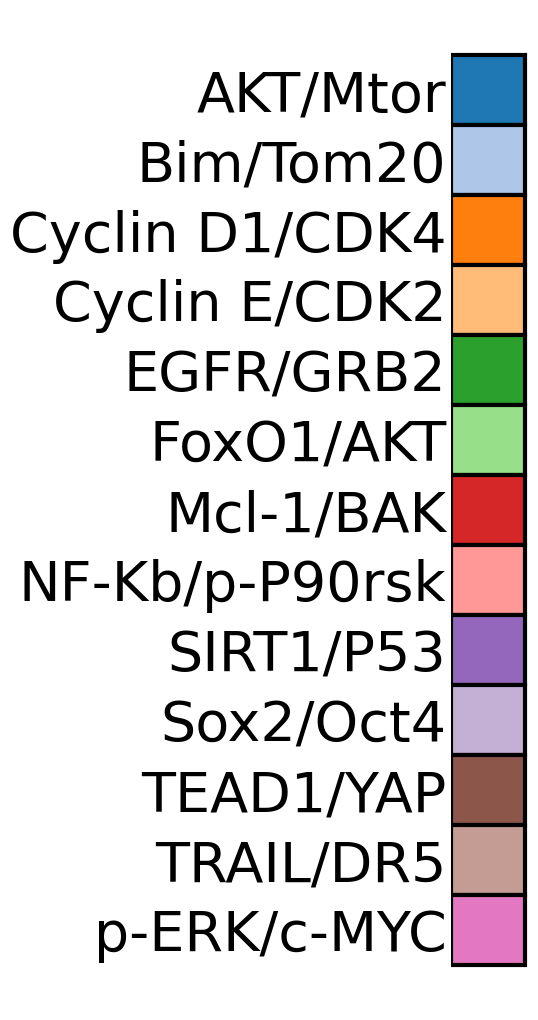

In [12]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [13]:
group = cell_data.df.groupby(['Condition', 'FOV'])

# Loop through Condition FOV
for name, df_group in group:
    # Get imgs shape 
    path = df_imgs[(df_imgs.Condition == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    with h5py.File(path, "r") as f:
        img_shape = f['imgs'].shape[1:]
    
    img_fov = np.zeros(img_shape)
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    ax.set_facecolor('k')

    # Get Individual cell
    for row in df_group.itertuples():
        key = '_'.join(row[1:3])
        cell = row[3]
        # Get contours
        contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
        contour = max(contour_cell, key = len)
        
        # Plot contours
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=0.5)
        
        # Get graph
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
        # Plot network
        plot_network(network,  node_colors, ax, node_size=1.5, linewidths=0.05, edgecolors='w', width=0.2, edge_color='w')
    
    file_name = '_'.join(name)
    fig.savefig(fig_path / f'{file_name}.png', dpi=1600, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

# Plot p-EGFR background with scatter dot

In [48]:
# Define figure file 
fig_path = fig_dir / '13cyc' / 'FOV_pEGFR'
fig_path.mkdir(parents=True, exist_ok=True)    

In [52]:
from matplotlib.colors import LinearSegmentedColormap
group = cell_data.df.groupby(['Condition', 'FOV'])

# Loop through Condition FOV
for name, df_group in group:
    # Get imgs shape 
    path = df_imgs[(df_imgs.Condition == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    with h5py.File(path, "r") as f:
        imgs = f['imgs'][:]
        markers = f['imgs'].attrs['Marker']
    
    # Get p-EGFR indice 
    pegfr_indice = list(markers).index('p-EGFR')

    # Plot figure
    fig, ax = plt.subplots(figsize=(10,5))
    ax.axis('off')
    ax.set_facecolor('k')
    img_fov = np.zeros(imgs[0].shape)
    ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)

    c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                                [[0.0, 0.0, 0.0, 0.0], 
                                                [0,0,1,1]])
    ax.imshow(imgs[3], vmin=10, vmax=np.quantile(imgs[3], 0.99), cmap=c_cmap)

    c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                                [[0.0, 0.0, 0.0, 0.0], 
                                                [1,1,0.2,1]])
    ax.imshow(imgs[pegfr_indice], vmin=0, vmax=np.quantile(imgs[pegfr_indice], 0.98), cmap=c_cmap)

    # Get Individual cell
    for row in df_group.itertuples():
        key = '_'.join(row[1:3])
        cell = row[3]
        
        # Get graph
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
        # Plot network
        plot_network(network,  node_colors, ax, node_size=0.5, linewidths=0, edgecolors='w', width=0, edge_color='w')
    
    file_name = '_'.join(name)
    fig.savefig(fig_path / f'{file_name}.png', dpi=2000, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

In [53]:
# from matplotlib.colors import LinearSegmentedColormap
# # Get p-EGFR indice 
# pegfr_indice = list(markers).index('p-EGFR')

# # Plot figure
# fig, ax = plt.subplots(figsize=(10,5))
# ax.axis('off')
# ax.set_facecolor('k')
# img_fov = np.zeros(imgs[0].shape)
# ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)

# c_cmap = LinearSegmentedColormap.from_list("Blue", 
#                                             [[0.0, 0.0, 0.0, 0.0], 
#                                              [0,0,1,1]])
# ax.imshow(imgs[3], vmin=10, vmax=np.quantile(img[3], 0.99), cmap=c_cmap)

# c_cmap = LinearSegmentedColormap.from_list("Blue", 
#                                             [[0.0, 0.0, 0.0, 0.0], 
#                                              [1,1,0.2,1]])
# ax.imshow(imgs[pegfr_indice], vmin=0, vmax=np.quantile(img[pegfr_indice], 0.98), cmap=c_cmap)



# Plot Cox iv background with scatter plot

In [23]:
# Define figure file 
fig_path = fig_dir / '13cyc' / 'FOV_COXIV'
fig_path.mkdir(parents=True, exist_ok=True)    

In [25]:
from matplotlib.colors import LinearSegmentedColormap
group = cell_data.df.groupby(['Condition', 'FOV'])

# Loop through Condition FOV
for name, df_group in group:
    # Get imgs shape 
    path = df_imgs[(df_imgs.Condition == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    with h5py.File(path, "r") as f:
        imgs = f['imgs'][:]
        markers = f['imgs'].attrs['Marker']
    
    # Get p-EGFR indice 
    pegfr_indice = list(markers).index('COX IV')

    # Plot figure
    fig, ax = plt.subplots(figsize=(10,5))
    ax.axis('off')
    ax.set_facecolor('k')
    img_fov = np.zeros(imgs[0].shape)
    ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)

    c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                                [[0.0, 0.0, 0.0, 0.0], 
                                                [0,0,1,1]])
    ax.imshow(imgs[3], vmin=10, vmax=np.quantile(imgs[3], 0.99), cmap=c_cmap)

    c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                                [[0.0, 0.0, 0.0, 0.0], 
                                                [1,1,0.2,1]])
    ax.imshow(imgs[pegfr_indice], vmin=0, vmax=np.quantile(imgs[pegfr_indice], 0.995), cmap=c_cmap)

    # Get Individual cell
    for row in df_group.itertuples():
        key = '_'.join(row[1:3])
        cell = row[3]
        
        # Get graph
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
        # Plot network
        plot_network(network,  node_colors, ax, node_size=0.35, linewidths=0, edgecolors='w', width=0, edge_color='w')
    
    file_name = '_'.join(name)
    fig.savefig(fig_path / f'{file_name}.png', dpi=2000, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

# Plot raw images with napari

In [20]:
# Helper functions

import napari
import vispy.color
import networkx as nx
from copy import deepcopy 

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax

# Read images
def read_img_bbox(path, bbox, pad = 20):
    min_y, min_x, max_y, max_x = bbox
    min_y = np.clip(min_y - pad, a_min=0, a_max=None)
    min_x = np.clip(min_x - pad, a_min=0, a_max=None)
    max_y += pad
    max_x += pad
    
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][..., min_y:max_y, min_x:max_x]
    
    return imgs, markers

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):

    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_screenshot(list_markers, markers, colors, c_limit_dict, contour=None, contour_nuclei=None, high_contrast=False):

    if high_contrast:
        c = [[10, c_limit_dict[n][1]+5] for n in list_markers]
    else:
        c = [c_limit_dict[n] for n in list_markers]
    indices = [list(markers).index(ele) for ele in list_markers]
    viewer = napari.view_image(img[indices], 
                    name=list_markers, 
                    channel_axis=0, 
                    colormap=colors, 
                    contrast_limits=c)
    if contour is not None:
        shapes_layer = viewer.add_shapes(contour, shape_type='polygon', edge_width=1,
                            edge_color='red', face_color=[0,0,0,0])
    if contour_nuclei is not None:
        shapes_layer = viewer.add_shapes(contour_nuclei, shape_type='polygon', edge_width=1,
                            edge_color='blue', face_color=[0,0,0,0])
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
    screenshot1 = removeBorders(screenshot)
    viewer.close()
    return screenshot1

In [21]:
# Load custom class
import PLA

graph_save_path =  data_dir / '13cyc' / 'graphs' / 'raw'
contour_save_path =  data_dir / '13cyc'/ 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

# Define figure file 
fig_path = fig_dir / '13cyc' / 'Cell_v2'
fig_path.mkdir(parents=True, exist_ok=True)    

# Define subset of plotting 
subset1 = ['Hoechst', 'Ki67', 'Pan-cytokeratin', 'p-EGFR',]
subset2 = ['Hoechst', 'NBD-C6',  'COX IV']
PPI_subset1 = ['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',  'Cyclin D1/CDK4', 'Bim/Tom20']
PPI_subset2 = ['EGFR/GRB2', 'FoxO1/AKT',  'p-ERK/c-MYC', 'Mcl-1/BAK',  'Cyclin E/CDK2',  'AKT/Mtor', 'TEAD1/YAP']

colors_rgb_dict_protein1 = {k:v for k,v in zip(subset1[1:], [[255,0,255], [0,255,0], [255,0,0]])}
colors_rgb_dict_protein2 = {k:v for k,v in zip(subset2[1:], [[255,0,255], [0,255,0]])}

Loading graphs
Loading contours


In [32]:
import palettable
from sklearn.preprocessing import OneHotEncoder

# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_20.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['AKT/Mtor', 'Bim/Tom20', 'Cyclin D1/CDK4', 'Cyclin E/CDK2',
       'EGFR/GRB2', 'FoxO1/AKT', 'Mcl-1/BAK', 'NF-Kb/p-P90rsk',
       'SIRT1/P53', 'Sox2/Oct4', 'TEAD1/YAP', 'TRAIL/DR5', 'p-ERK/c-MYC'],
      dtype=object)]


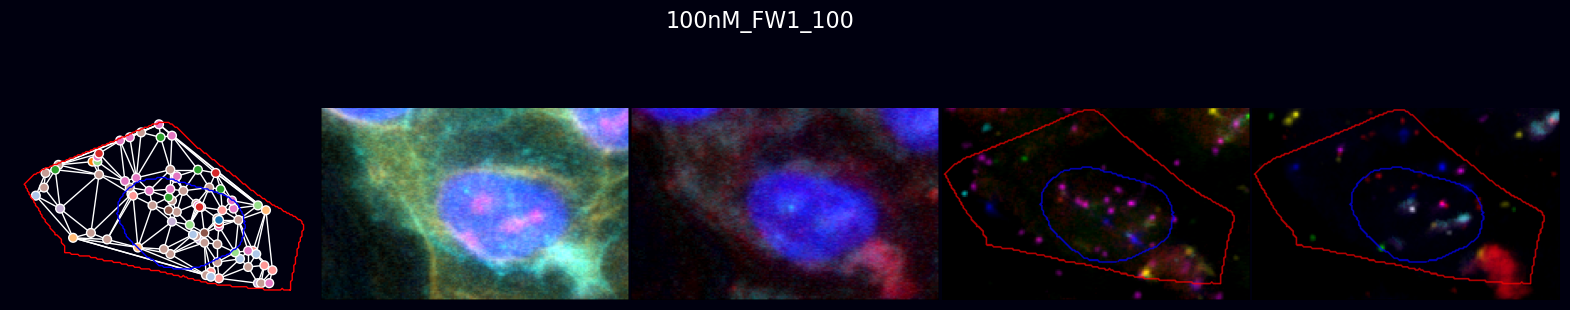

In [33]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]

    if cell =='0':
        continue
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        pass
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Condition == row.Condition)].Path.item()
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = deepcopy(max(contour_cell, key = len))
    contour_nuclei = deepcopy(max(contour_nuclei, key = len))
    max_y, max_x = contour.max(axis=0).astype(int)
    min_y, min_x = contour.min(axis=0).astype(int)
    contour_offset = deepcopy(contour) - np.array([min_y, min_x])
    contour_nuclei_offset = deepcopy(contour_nuclei) - np.array([min_y, min_x])

    # Get mutiplex images
    img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)

    # Get contrast limits range
    c_limit_dict = {}
    for n in np.unique(markers):
        indice = list(markers).index(n)
        max_c = np.quantile(img[indice], 1.0)
        c_limit_dict[n] = [0, max_c+10]

    # Get network
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))

    # Define node colors
    nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

    screenshot1 = get_screenshot(subset1, markers, ['blue', 'red', "bop orange", 'cyan'], c_limit_dict)
    screenshot2 = get_screenshot(subset2, markers, ['blue', 'red', 'cyan', "bop orange",], c_limit_dict)
    screenshot3 = get_screenshot(PPI_subset1, markers, ['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], c_limit_dict, 
                                 contour=contour_offset, contour_nuclei=contour_nuclei_offset, high_contrast=True)
    screenshot4 = get_screenshot(PPI_subset2, markers, ['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], c_limit_dict, 
                                 contour=contour_offset, contour_nuclei=contour_nuclei_offset, high_contrast=True)

    with plt.style.context('dark_background'):
        # Plot Graph
        f, axs = plt.subplots(1, 5, figsize=(20,4), facecolor='k')
        ax = axs[0]
        plot_network(network,  node_colors, ax, node_size=40, edgecolors='w', width=1, edge_color='w')
        plot_contour(contour_cell, [contour_nuclei], ax, linewidth=1)

        axs[1].imshow(screenshot1)
        axs[2].imshow(screenshot2)
        axs[3].imshow(screenshot3)
        axs[4].imshow(screenshot4)
        for ax in axs:
            ax.axis('off')
            ax.set_facecolor('k')
        axs[0].invert_yaxis()
        axs[0].set_aspect('equal')
        f.set_facecolor("#00000F")
        f.subplots_adjust(wspace=0.01)
        f.suptitle(f'{key}_{cell}', fontsize=16, color='w')
        plt.show()
    break

In [10]:
# ### 1
# list_markers = subset1

# indices = [list(markers).index(ele) for ele in list_markers]
# viewer = napari.view_image(img[indices], 
#                   name=list_markers, 
#                   channel_axis=0, 
#                   colormap=['blue', 'red', "bop orange", 'cyan'], 
#                   contrast_limits=[c_limit_dict[n] for n in list_markers],)
# # Get screenshot
# screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
# screenshot1 = removeBorders(screenshot)
# viewer.close()

# ### 2
# list_markers = subset2

# indices = [list(markers).index(ele) for ele in list_markers]
# viewer = napari.view_image(img[indices], 
#                   name=list_markers, 
#                   channel_axis=0, 
#                   colormap=['blue', 'red', 'cyan', "bop orange",], 
#                   contrast_limits=[c_limit_dict[n] for n in list_markers],)
# # Get screenshot
# screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
# screenshot2 = removeBorders(screenshot)
# viewer.close()

# ### 3
# list_markers = PPI_subset1

# indices = [list(markers).index(ele) for ele in list_markers]
# viewer = napari.view_image(img[indices], 
#                   name=list_markers, 
#                   channel_axis=0, 
#                   colormap=['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], 
#                   contrast_limits=[[10, c_limit_dict[n][1]+5] for n in list_markers],)
# shapes_layer = viewer.add_shapes(contour_offset, shape_type='polygon', edge_width=1,
#                           edge_color='red', face_color=[0,0,0,0])
# shapes_layer = viewer.add_shapes(contour_nuclei_offset, shape_type='polygon', edge_width=1,
#                           edge_color='blue', face_color=[0,0,0,0])
# # Get screenshot
# screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
# screenshot3 = removeBorders(screenshot)
# viewer.close()

# ### 4
# list_markers = PPI_subset2

# indices = [list(markers).index(ele) for ele in list_markers]
# viewer = napari.view_image(img[indices], 
#                   name=list_markers, 
#                   channel_axis=0, 
#                   colormap=['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], 
#                   contrast_limits=[[10, c_limit_dict[n][1]+5] for n in list_markers],)
# shapes_layer = viewer.add_shapes(contour_offset, shape_type='polygon', edge_width=1,
#                           edge_color='red', face_color=[0,0,0,0])
# shapes_layer = viewer.add_shapes(contour_nuclei_offset, shape_type='polygon', edge_width=1,
#                           edge_color='blue', face_color=[0,0,0,0])
# # Get screenshot
# screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
# screenshot4 = removeBorders(screenshot)
# viewer.close()

In [ ]:
# with plt.style.context('dark_background'):
#     # Plot Graph
#     f, axs = plt.subplots(1, 5, figsize=(20,4), facecolor='k')
#     ax = axs[0]
#     plot_network(network,  node_colors, ax, node_size=40, edgecolors='w', width=1, edge_color='w')
#     plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)

#     axs[1].imshow(screenshot1)
#     axs[2].imshow(screenshot2)
#     axs[3].imshow(screenshot3)
#     axs[4].imshow(screenshot4)
#     for ax in axs:
#         ax.axis('off')
#         ax.set_facecolor('k')
#     axs[0].invert_yaxis()
#     axs[0].set_aspect('equal')
#     f.set_facecolor("#00000F")
#     f.subplots_adjust(wspace=0.01)
#     f.suptitle(f'{key}_{cell}', fontsize=16, color='w')
#     plt.show()

In [36]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]

    if cell =='0':
        continue
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        pass
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Condition == row.Condition)].Path.item()
    try:
        # Get contours
        contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
        contour = deepcopy(max(contour_cell, key = len))
        contour_nuclei = deepcopy(max(contour_nuclei, key = len))
        max_y, max_x = contour.max(axis=0).astype(int)
        min_y, min_x = contour.min(axis=0).astype(int)
        contour_offset = deepcopy(contour) - np.array([min_y, min_x])
        contour_nuclei_offset = deepcopy(contour_nuclei) - np.array([min_y, min_x])

        # Get mutiplex images
        img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)

        # Get contrast limits range
        c_limit_dict = {}
        for n in np.unique(markers):
            indice = list(markers).index(n)
            max_c = np.quantile(img[indice], 1.0)
            c_limit_dict[n] = [0, max_c+10]

        # Get network
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        # Define node colors
        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

        screenshot1 = get_screenshot(subset1, markers, ['blue', 'red', "bop orange", 'cyan'], c_limit_dict)
        screenshot2 = get_screenshot(subset2, markers, ['blue', 'red', 'cyan', "bop orange",], c_limit_dict)
        screenshot3 = get_screenshot(PPI_subset1, markers, ['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], c_limit_dict, 
                                    contour=contour_offset, contour_nuclei=contour_nuclei_offset, high_contrast=True)
        screenshot4 = get_screenshot(PPI_subset2, markers, ['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray'], c_limit_dict, 
                                    contour=contour_offset, contour_nuclei=contour_nuclei_offset, high_contrast=True)

        with plt.style.context('dark_background'):
            # Plot Graph
            f, axs = plt.subplots(1, 5, figsize=(20,4), facecolor='k')
            ax = axs[0]
            plot_network(network,  node_colors, ax, node_size=45, edgecolors='w', width=1, edge_color='w')
            plot_contour(contour_cell, [contour_nuclei], ax, linewidth=1)

            axs[1].imshow(screenshot1)
            axs[2].imshow(screenshot2)
            axs[3].imshow(screenshot3)
            axs[4].imshow(screenshot4)
            for ax in axs:
                ax.axis('off')
                ax.set_facecolor('k')
            axs[0].invert_yaxis()
            axs[0].set_aspect('equal')
            f.set_facecolor("#00000F")
            f.subplots_adjust(wspace=0.01)
            f.suptitle(f'{key}_{cell}', fontsize=16, color='w')

            file_name = '_'.join([key, cell])
            f.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()
    except:continue
    

C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:710: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\vispy\gloo\buffer.py:433: RuntimeWarning: overflow encountered in cast
  data = data.astype(np.float32)
C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:710: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\vispy\gloo\buffer.py:433: RuntimeWarning: overflow encountered in cast
  data = data.astype(np.float32)
C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:710: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\thu71\AppData\Local\anaconda3\envs\scan

# Plot PPI scatter plot

In [22]:
def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

    
def plot_PPI_scatter(points, colors, c_limit_dict, img, contour=None, contour_nuclei=None):
    # Napari viewer
    viewer = napari.view_image(img[3], colormap='blue', contrast_limits=c_limit_dict['Hoechst'])
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=5,face_color=colors[j])
    
    if contour is not None:
        shapes_layer = viewer.add_shapes(contour, shape_type='polygon', edge_width=1,
                            edge_color='red', face_color=[0,0,0,0])
    if contour_nuclei is not None:
        shapes_layer = viewer.add_shapes(contour_nuclei, shape_type='polygon', edge_width=1,
                            edge_color='blue', face_color=[0,0,0,0])
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
    screenshot1 = removeBorders(screenshot)
    viewer.close()
    return screenshot1

In [23]:
# Read PPI 
PPI_save_path =  data_dir / '13cyc'  / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df = df.rename(columns={'x': 'row', 'y': 'column'})
df.head()

# Define figure file 
fig_path = fig_dir / '13cyc' / 'Cell_scatter'
fig_path.mkdir(parents=True, exist_ok=True)    

In [93]:
df_subset = cell_data.df

pad = 0
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]

    if cell =='0':
        continue
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        pass
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Condition == row.Condition)].Path.item()
    try:
        # Get contours
        contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
        contour = deepcopy(max(contour_cell, key = len))
        contour_nuclei = deepcopy(max(contour_nuclei, key = len))
        max_y, max_x = contour.max(axis=0).astype(int)
        min_y, min_x = contour.min(axis=0).astype(int)
        contour_offset = deepcopy(contour) - np.array([min_y, min_x])
        contour_nuclei_offset = deepcopy(contour_nuclei) - np.array([min_y, min_x])

        # Get mutiplex images
        img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)

        # Get contrast limits range
        c_limit_dict = {}
        for n in np.unique(markers):
            indice = list(markers).index(n)
            max_c = np.quantile(img[indice], 1.0)
            c_limit_dict[n] = [0, max_c+10]

        # Get network
        network = read_pkl(row.Path)
        network.remove_edges_from(list(nx.selfloop_edges(network)))

        # Define node colors
        nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
        labels = list(nx.get_node_attributes(network, 'labels').values())
        labels = np.argmax(labels, axis=1)
        node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

        screenshot1 = get_screenshot(subset1, markers, ['blue', 'red', "bop orange", 'cyan'], c_limit_dict)
        screenshot2 = get_screenshot(subset2, markers, ['blue', 'red', 'cyan', "bop orange",], c_limit_dict)

        points = [get_loc_ppi(df, row.Condition, row.FOV, min_x, min_y, max_x, max_y, PPI_name) for PPI_name in PPI_subset1]
        colors =  ['blue', 'yellow', 'red', 'magenta', 'green', 'cyan', 'gray']
        screenshot3 = plot_PPI_scatter(points, colors, c_limit_dict, img, contour=contour_offset, contour_nuclei=contour_nuclei_offset)
        points = [get_loc_ppi(df, row.Condition, row.FOV, min_x, min_y, max_x, max_y, PPI_name) for PPI_name in PPI_subset2]
        screenshot4 = plot_PPI_scatter(points, colors, c_limit_dict, img, contour=contour_offset, contour_nuclei=contour_nuclei_offset)

        with plt.style.context('dark_background'):
            # Plot Graph
            f, axs = plt.subplots(1, 5, figsize=(20,4), facecolor='k')
            ax = axs[0]
            plot_network(network,  node_colors, ax, node_size=40, edgecolors='w', width=1, edge_color='w')
            plot_contour(contour_cell, [contour_nuclei], ax, linewidth=1)

            axs[1].imshow(screenshot1)
            axs[2].imshow(screenshot2)
            axs[3].imshow(screenshot3)
            axs[4].imshow(screenshot4)
            for ax in axs:
                ax.axis('off')
                ax.set_facecolor('k')
            axs[0].invert_yaxis()
            axs[0].set_aspect('equal')
            f.set_facecolor("#00000F")
            f.subplots_adjust(wspace=0.01)
            f.suptitle(f'{key}_{cell}', fontsize=16, color='w')
            
            file_name = '_'.join([key, cell])
            f.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()
    except:continue


C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:710: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\vispy\gloo\buffer.py:433: RuntimeWarning: overflow encountered in cast
  data = data.astype(np.float32)
C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:627: RuntimeWarning: invalid value encountered in cast
  y = np.sign(x).astype(int)
C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\layers\shapes\_shapes_utils.py:710: RuntimeWarning: overflow encountered in square
  miter_lengths_squared = (miters**2).sum(axis=1)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\vispy\gloo\buffer.py:433: RuntimeWarning: overflow encountered in cast
  data = data.astype(np.float32)
C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napa

# Test torch geometric

In [26]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]

    if cell =='0':
        continue

    # Get graph
    network = read_pkl(row.Path)

In [27]:
import torch_geometric

In [29]:
data = torch_geometric.utils.from_networkx(network)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  data[key] = torch.tensor(value)


In [30]:
data

Data(edge_index=[2, 562], pos=[98, 2], labels=[98, 13], nuclei=[98], weight=[562])